<a href="https://colab.research.google.com/github/oagbohouto86/challenge_qrt/blob/master/dm_qrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of overall survival in patients with Myeloid Leukemia**

## **Challenge description**

**A- Goal**

The goal of this challenge organized by QRT and Institut Gustave Roussy - 2025, is to **predict accurately survival for patients diagnosed with blood cancer, specifically within subtypes of adult myeloid leukemias.** Overall survival is described by the period between the initial diagnosis to either the patient’s death or the lost to follow-up.\
Accurate risk predictions could lead to better clinical decision-making, improved patient outcomes, and more efficient resource allocation within healthcare facilities.

**B- Data Overview**

We get two sets of data:
  - **training set with 3323 patients** which will be used to set our model (feature management and engineering, hyperparameters tuning and learning)
  - **test set with 1193 patients** for which we will predict the risk score using their features.

There are two types of features:
  - **clinical features (one row per patient)** including the clinical center, bone marrow blasts percentage, WBC count, ANC count, monocytes count, HB level, platelet count and cytogenetics.
  - **Gene molecular features (one row per somatic mutation per patient)**. Somatic (acquired) mutations are mutations specific to cancerous cells, not found in the patient’s normal cells.

The outcomes provided in Y_train set are the overall survival time in years from diagnosis (OS_YEARS) and the censoring indicator (OS_STATUS) denoting death or alive or lost to FUP of each patient in training set. Then **the expected output will be the predicted risk of death (risk score) for each patient in test set**.

**C- Metric**

**The loss metric is the Concordance Index for Right-Censored Data with IPCW (IPCW-C-index)**. This metric is an extension of classical c-index used to measures how well a predictive model can correctly rank survival times. This extension apply inverse probability of censoring weights (IPCW) depending on censored data to better handle right-censored data. \
This metric as well as classical c-index are implemented in scikit-survival python package.

**D- Benchmark**

The first benchmark (LGBM model) is provided as an example. The actual score obtained with the second benchmark (Cox model) is equal to **0.6541** and is the one expected to exceed.

## **Packages and data loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set options and import librairies
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gc
gc.collect()

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree

import sksurv
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw

os.chdir("/content/drive/MyDrive/Challenges/QRT")

In [8]:
# Clinical data
clin_train_df=pd.read_csv("./X_train/clinical_train.csv")
clin_test_df=pd.read_csv("./X_test/clinical_test.csv")

# Molecular data
mol_train_df=pd.read_csv("./X_train/molecular_train.csv")
mol_test_df=pd.read_csv("./X_test/molecular_test.csv")

# Y train (OS YEAR and STATUS)
y_train=pd.read_csv("./target_train.csv")

In [15]:
clin_train_df.head()
mol_train_df.head()
y_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0


In [16]:
clin_train_df.info()
mol_train_df.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10935 non-null  object 
 1   CHR             10821 non-null  object 
 2   START           10821 non-null  float64
 3   END             10821 non-nu

## **Exploratory analysis**

### Clinical data

In [19]:
#@title Info
clin_train_df.info()
clin_train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [44]:
#@title Overview and description of float variables
clin_train_df.select_dtypes("float").describe()
float_col=clin_train_df.select_dtypes("float").columns
missing_values = clin_train_df.isnull().sum()
print(missing_values[missing_values > 0])
# Results below shows that monocytes variables have more missing data (around 601 or 18% of missing data). Either I will impute this data or I will remove missing lines or
# exclude it from analysis. For variables BM_BLAST, WBC, ANC, HB and PLT, I will either imput missing data or remove missing lines.
# With this result I suspect presence of outliers and asymetric data.

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3214.000000,3051.000000,3130.000000,2722.000000,3213.000000,3199.000000
mean,5.982545,6.535164,3.264735,0.955868,9.893549,167.048900
std,7.615439,10.247219,5.237043,2.666478,2.041158,149.477031
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.150000,8.500000,65.500000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.655000,3.690000,0.783000,11.200000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64


<Axes: ylabel='BM_BLAST'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST')

<Axes: ylabel='WBC'>

Text(0.5, 1.0, 'Boxplot of WBC')

<Axes: ylabel='ANC'>

Text(0.5, 1.0, 'Boxplot of ANC')

<Axes: ylabel='MONOCYTES'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES')

<Axes: ylabel='HB'>

Text(0.5, 1.0, 'Boxplot of HB')

<Axes: ylabel='PLT'>

Text(0.5, 1.0, 'Boxplot of PLT')

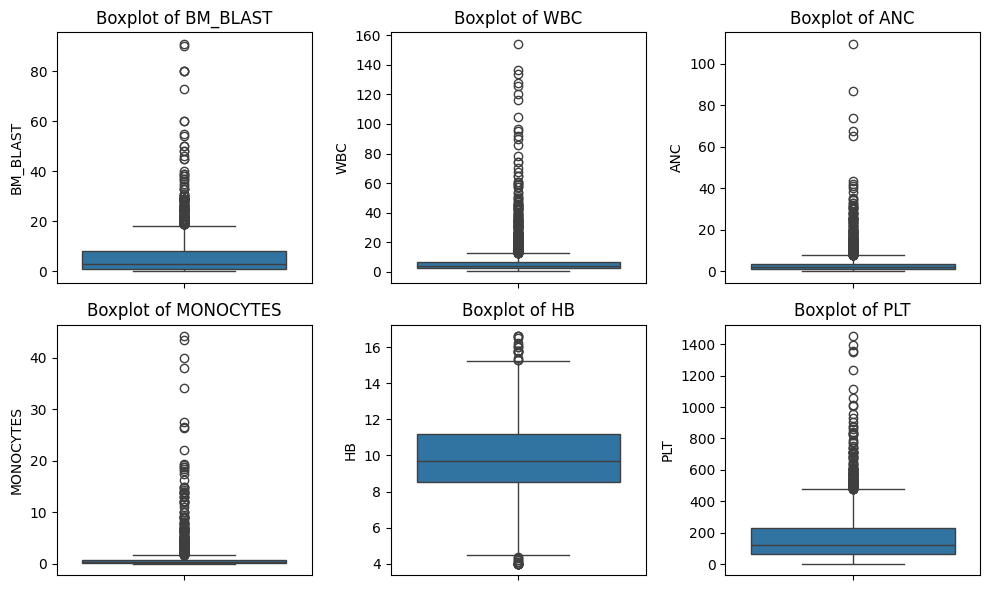

In [38]:
#@title Box plots of float variables to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(clin_train_df.select_dtypes("float").columns):
  sns.boxplot(clin_train_df, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
#@markdown This figure sugger that variables have many outliers and then asymetric distribution and high dispersion. Also PLT is not in the same scale as the the others variables.
# So in next step, I will need to detect and handle these outliers, transform variables in log scale or in using box-cox, and standardize these features

In [52]:
#@title Correlation between variables
cor=clin_train_df.select_dtypes("float").corr("spearman")
corr_perfect = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
corr_perfect

[('WBC', 'ANC'), ('WBC', 'MONOCYTES'), ('ANC', 'WBC'), ('MONOCYTES', 'WBC')]

<Axes: xlabel='BM_BLAST', ylabel='WBC'>

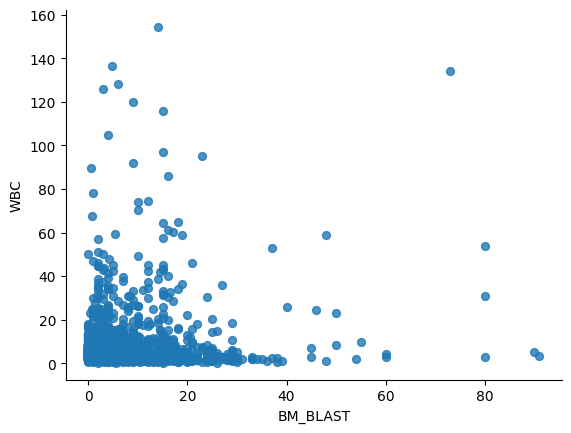

In [46]:
# @title BM_BLAST vs WBC

from matplotlib import pyplot as plt
clin_train_df.plot(kind='scatter', x='BM_BLAST', y='WBC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Molecular data

## **Feature engineering**

### Clinical data

##### Missing data handling

##### Outliers handling

##### Features extractions

##### Features selection

##### Encode categorical features

##### Standardization

### Molecular data

##### Missing data handling

##### Outliers handling

##### Features extractions

##### Features selection

##### Encode categorical features

##### Standardization

### Target

### Merge data

## **Models**